# DRL Course 2023 Домашнее задание 2 #

Отчет по выполнению домашнего задания, Nikita Sorokin

In [1]:
import torch
from torch import nn
import numpy as np
import gym
import matplotlib.pyplot as plt
from matplotlib import animation

import seaborn as sns
sns.set()

In [2]:
def save_frames_as_gif(frames, path='./', filename='gym_animation.gif'):

    #Mess with this to change frame size
    plt.figure(figsize=(frames[0].shape[1] / 50.0, frames[0].shape[0] / 50.0), dpi=72)

    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    anim.save(path + filename, writer='imagemagick', fps=60)

## Используемые алгоритмы

### Cross-Entropy Method. Case $ S \subset \mathbb{R}^n, \,\, |A| = m $ ###

В код добавленный на семинаре была добавлена возможность использовать шум для начального обучения в случаях неудачной инициализации нейронной сети, однако при выполнении задания не получилось извлечь из шума какой-либо пользы, только более долгое обучение...

In [ ]:
class CEM(nn.Module):
    def __init__(self, state_dim, action_n):
        super().__init__()
        self.state_dim = state_dim
        self.action_n = action_n

        self.network = nn.Sequential(
            nn.Linear(self.state_dim, 100),
            nn.ReLU(),
            nn.Linear(100, self.action_n)
        )

        self.softmax = nn.Softmax()
        self.optimizer = torch.optim.Adam(self.parameters(), lr=1e-2, betas=(0.9, 0.999))
        self.loss = nn.CrossEntropyLoss()

    def forward(self, _input):
        return self.network(_input)

    def get_action(self, state, eps=0, discrete_action=False):
        state = torch.FloatTensor(state)
        logits = self.forward(state)
        noise = torch.FloatTensor([1 / self.action_n for _ in range(self.action_n)])
        action_prob = (1 - eps) * self.softmax(logits) + eps * noise
        action_prob = action_prob.detach().numpy()
        action = np.random.choice(self.action_n, p=action_prob)
        self.optimizer.zero_grad()

        return action

    def update_policy(self, elite_trajectories):
        elite_states = []
        elite_actions = []
        for trajectory in elite_trajectories:
            elite_states.extend(trajectory['states'])
            elite_actions.extend(trajectory['actions'])
        elite_actions = torch.LongTensor(elite_actions)
        elite_states = torch.FloatTensor(elite_states[:list(elite_actions.shape)[0]])

        loss = self.loss(self.forward(elite_states), elite_actions)
        loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()

In [ ]:
def get_trajectory(env, agent, trajectory_len, eps=0, visualize=False, filename='gym_animation.gif', discrete_action=False):
    trajectory = {'states':[], 'actions': [], 'total_reward': 0}

    state = env.reset()
    trajectory['states'].append(state)

    frames = []
    for i in range(trajectory_len):

        action = agent.get_action(state, eps, discrete_action)
        trajectory['actions'].append(action)

        state, reward, done, _ = env.step(action)
        trajectory['total_reward'] += reward

        if done:
            break

        if visualize:
            frames.append(env.render(mode="rgb_array"))

        if i != trajectory_len - 1:
            trajectory['states'].append(state)

    if visualize:
        save_frames_as_gif(frames, filename=filename)

    return trajectory

def get_elite_trajectories(trajectories, q_param):
    total_rewards = [trajectory['total_reward'] for trajectory in trajectories]
    quantile = np.quantile(total_rewards, q=q_param)
    return [trajectory for trajectory in trajectories if trajectory['total_reward'] > quantile]

In [ ]:
def train(env, agent, episode_n, trajectory_n, trajectory_len, q_param, noise=False, autosave=False, discrete_action=False):
    rewards = []
    max_reward = -5000
    for episode in range(episode_n):

        eps = 0
        if noise == True:
            eps = 1 / np.sqrt(episode + 1)

        trajectories = [get_trajectory(env, agent, trajectory_len, eps, discrete_action=discrete_action) for _ in range(trajectory_n)]
        mean_total_reward = np.mean([trajectory['total_reward'] for trajectory in trajectories])

        if autosave == True:
            if mean_total_reward < max_reward:
                continue
        max_reward = mean_total_reward

        rewards.append(mean_total_reward)
        print(f'episode: {episode}, mean_total_reward = {mean_total_reward}')

        elite_trajectories = get_elite_trajectories(trajectories, q_param)
        if len(elite_trajectories) > 0:
            agent.update_policy(elite_trajectories)

    return rewards

### Cross-Entropy Method. Case $ S \subset \mathbb{R}^n, \,\, A \subset \mathbb{R}^m $ ###

Для реализации метода кросс-энтропии в случае непрерывного пространства действий мы переходим от задачи классификации к задаче регрессии. Значит заменяем CrossEntropyLoss на MSELoss, а также избавляемся от софтмакса.

In [ ]:
class CEM_continuous(nn.Module):
    def __init__(self, state_dim, action_dim, min_action, max_action):
        super().__init__()
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.min_action = min_action
        self.max_action = max_action

        self.network = nn.Sequential(
            nn.Linear(self.state_dim, 100),
            nn.ReLU(),
            nn.Linear(100, self.action_dim)
        )

        self.optimizer = torch.optim.Adam(self.parameters(), lr=1e-1, betas=(0.9, 0.999))
        self.loss = nn.MSELoss()

    def forward(self, _input):
        return self.network(_input)

    def get_action(self, state, eps=0, discrete_action=False):
        state = torch.FloatTensor(state)
        self.min_action = torch.FloatTensor([self.min_action])
        self.max_action = torch.FloatTensor([self.max_action])

        noise = torch.randn(self.action_dim)
        noise = 2 if noise > 0 else -2

        with torch.no_grad():
            action = torch.clamp(self.forward(state) + eps * noise,
                                 min=self.min_action, max=self.max_action)
        action = action.detach().numpy()

        if discrete_action == True:
            action = list([2 if action > 0 else -2])

        return action

    def update_policy(self, elite_trajectories):
        elite_states = []
        elite_actions = []
        for trajectory in elite_trajectories:
            elite_states.extend(trajectory['states'])
            elite_actions.extend(trajectory['actions'])
        elite_states = torch.FloatTensor(elite_states)
        elite_actions = torch.FloatTensor(elite_actions)

        loss = self.loss(self.forward(elite_states), elite_actions)
        loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()

## Задание 1

Пользуясь алгоритмом Кросс-Энтропии для конечного пространства действий обучить агента решать Acrobot-v1 или LunarLander-v2 на выбор. Исследовать гиперпараметры алгоритма и выбрать лучшие.

### CartPole-v1 ###

In [ ]:
env = gym.make('CartPole-v1')
state_dim = 4
action_n = 2

agent = CEM(state_dim, action_n)

In [ ]:
episode_n = 100
trajectory_n = 20
trajectory_len = 500
q_param = 0.8

In [ ]:
train(env, agent, episode_n, trajectory_n, trajectory_len, q_param)

In [ ]:
trajectory = get_trajectory(env, agent, trajectory_len, visualize=True, filename='cartpole.gif')
print(f"total reward: {trajectory['total_reward']}")

### Acrobot-v1 ###


Для решения используется модель построенная на семинаре: нет шума, 1 скрытый слой из 100 нейронов, функция активации ReLU

Выбранные гиперпараметры обучения:

```python

episode_n = 100
trajectory_n = 20
trajectory_len = 500
q_param = 0.8

```

In [44]:
env = gym.make('Acrobot-v1')
state_dim = 6
action_n = 3

In [45]:
agent = CEM(state_dim, action_n)

In [46]:
episode_n = 100
trajectory_n = 20
trajectory_len = 500
q_param = 0.8

In [ ]:
rewards_acrobot = train(env, agent, episode_n, trajectory_n, trajectory_len, q_param)

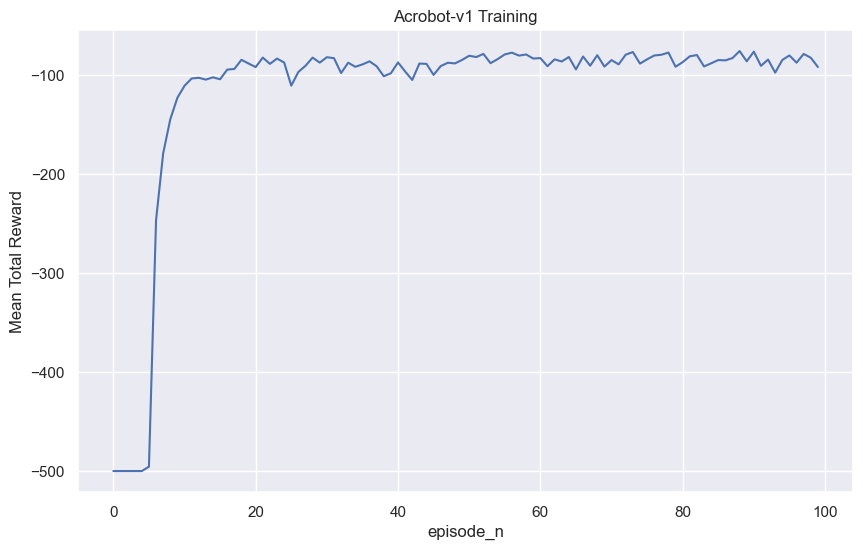

In [48]:
fig, axs = plt.subplots(figsize=(10, 6))

axs.set_title('Acrobot-v1 Training')
axs.set_xlabel('episode_n')
axs.set_ylabel('Mean Total Reward')

plt.plot(rewards_acrobot)
plt.savefig('acrobot_training.png')

### LunarLander-v2  ###


Для решения поставленной задачи было переброваны различные варианты шума, гиперпараметры и архитектуры классифицирующей нейронной сети. Однако я получил наиболее быструю сходимость на параметрах предыдущих заданиях с достаточно большим количеством эпох и везением :).

In [24]:
env = gym.make('LunarLander-v2')
state_dim = 8
action_n = 4

In [35]:
agent = CEM(state_dim, action_n)

In [25]:
episode_n = 100
trajectory_n = 20
trajectory_len = 1000
q_param = 0.8

In [ ]:
rewards_lunarlander = train(env, agent, episode_n, trajectory_n, trajectory_len, q_param)

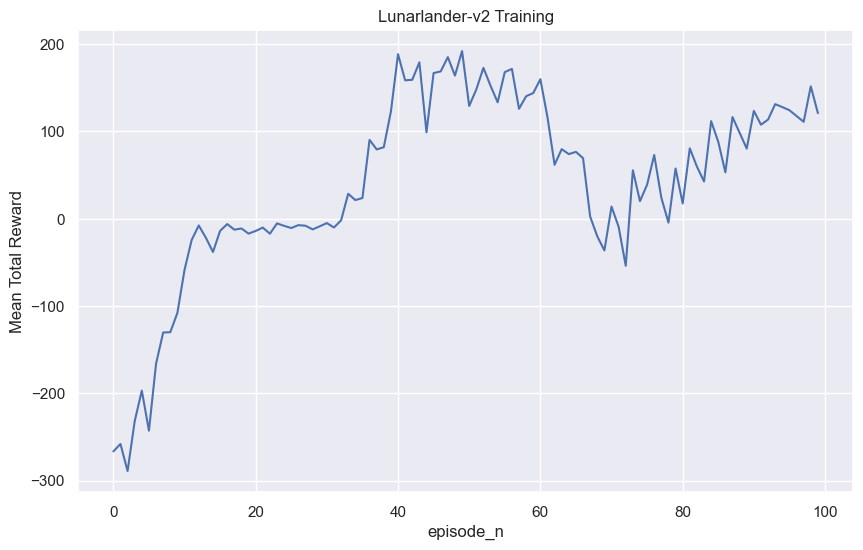

In [ ]:
fig, axs = plt.subplots(figsize=(10, 6))

axs.set_title('Lunarlander-v2 Training')
axs.set_xlabel('episode_n')
axs.set_ylabel('Mean Total Reward')

plt.plot(rewards_lunarlander)
plt.savefig('lunarlander_training.png')

In [38]:
rewards = []
for i in range(100):
    trajectory = get_trajectory(env, agent, trajectory_len)
    rewards.append(trajectory['total_reward'])

print(f'mean total reward on 100 validation trajectories: {np.mean(rewards)}')

mean total reward on 100 validation trajectories: 260.81608275891546


## Задание 2

Реализовать алгоритм Кросс-Энтропии для непрерывного пространства действий. Обучить агента решать Pendulum-v1 или MountainCarContinuous-v0 на выбор. Исследовать гиперпараметры алгоритма и выбрать лучшие.

### Pendulum-v1 ###

Обучение маятника проходила в несколько этапов с приминением различных хитростей.

1. Учимся с большим количеством шума, причем разрешаем всего 2 действия 2 и -2 из всего отрезка действий [-2, 2]. Это ограничение позволяет маятнику научиться уверенно раскачиваться. За эту функцию отвечает условие discrete_action = True.

2. Оставляем шум, возвращаем возможность выполнять все действия в отрезке [-2, 2]. Этот этап позволяет научиться маятнику выбирать действия, когда он проходит положение неустойчивого равновесия наверху.

3. Убираем шум, разрешаем действия 2 и -2. К тому же теперь используем условие autosave = True, которое не позволяет модели учиться если mean_total_reward полученный в текущем эпизоде меньше предыдущего. Этот этап позволяет уверенно управлять маятником, когда тот находится наверху и пытается устоять.

Используемые гиперпараметры:

```python

episode_n = 150
trajectory_n = 400
trajectory_len = 200
q_param = 0.9

agent.optimizer = torch.optim.Adam(agent.parameters(), lr=1e-1)

```

In [ ]:
env = gym.make('Pendulum-v1')
state_dim = 3
action_dim = 1
min_action = -2.0
max_action = 2.0

In [ ]:
agent = CEM_continuous(state_dim, action_dim, min_action, max_action)
rewards_pendulum = []

In [14]:
episode_n = 10
trajectory_n = 200
trajectory_len = 200
q_param = 0.99

agent.optimizer = torch.optim.Adam(agent.parameters(), lr=1e-1)

In [ ]:
train(env, agent, episode_n, trajectory_n, trajectory_len, q_param)

In [17]:
rewards = []
for i in range(100):
    trajectory = get_trajectory(env, agent, trajectory_len, visualize=False, discrete_action=True)
    rewards.append(trajectory['total_reward'])
    #print(f"total reward: {trajectory['total_reward']}")

print(f'mean total reward on 100 validation trajectories: {np.mean(rewards)}')

mean total reward on 100 validation trajectories: -271.5709711845613


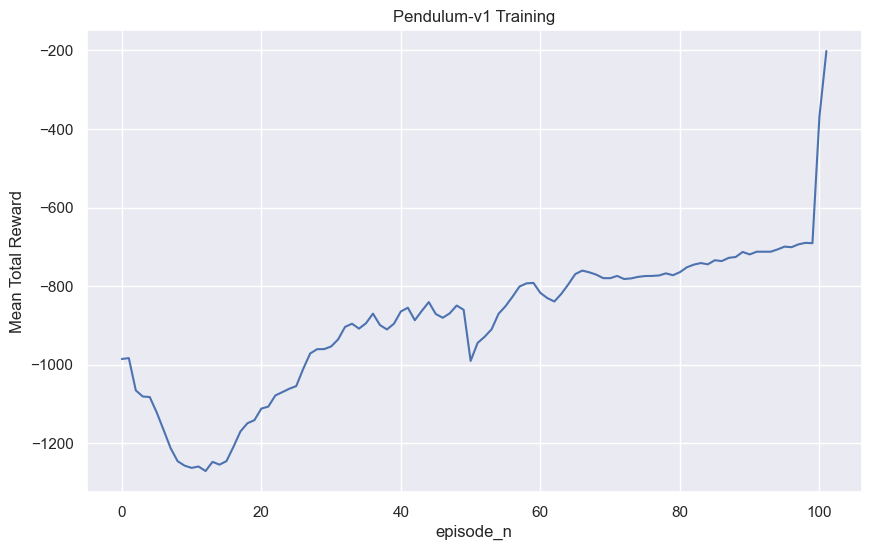

In [15]:
fig, axs = plt.subplots(figsize=(10, 6))

axs.set_title('Pendulum-v1 Training')
axs.set_xlabel('episode_n')
axs.set_ylabel('Mean Total Reward')

plt.plot(rewards_pendulum)
plt.savefig('pendulum_training.png')

### MountainCarContinuous-v0 ###


Не пытался решить задачу.

In [ ]:
env = gym.make('MountainCarContinuous-v0')
state_dim = 2
action_dim = 1
min_action = -1.0
max_action = 1.0

agent = CEM_continuous(state_dim, action_dim, min_action, max_action)
episode_n = 10
trajectory_n = 20
trajectory_len = 200
q_param = 0.6

In [ ]:
train(env, agent, episode_n, trajectory_n, trajectory_len, q_param)

In [ ]:
get_trajectory(env, agent, trajectory_len, visualize=True, filename="mountaincar.gif")